In [34]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

#### Importing the data

In [35]:
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=4c5e1e4c-c2c1-4b2a-9cb2-94133bd1d3b2
To: /content/Images for project.zip
100% 1.42G/1.42G [00:16<00:00, 85.1MB/s]


In [ ]:
!unzip -q "/content/Images for project.zip" -d /content/

replace /content/Images for project/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [ ]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [ ]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [ ]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [ ]:
proportion = {
    'train': 0.75,
    'val': 0.05,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

In [ ]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

In [ ]:
#### Here starts the part I changed

# Define Data Generators (Rest comes when we compile and train)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating Callbacks

In [ ]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-n:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')

In [ ]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

In [ ]:
# define here also metric of f1
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1_score')

In [ ]:
# Creatings instances
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

plot_metrics_callback = PlotMetricsCallback()




# Creating the Model

In [18]:
# Instance of our pretrained model we will use

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Make only the top layers of the base model trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
# reusable function

def compile_and_train_model(optimizer, batch_size=128, epochs=30, use_class_weights=False, input_size = (128,128)):
    train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=input_size)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size=input_size)

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', weighted_f1_score])

    # instance for top_n_accuracy
    top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

    callbacks = [reduce_lr, early_stopping, model_checkpoint, clear_output_callback,
                 plot_metrics_callback, top_n_accuracy_callback]

    if use_class_weights:
        class_weights = dict(enumerate(compute_class_weight('balanced',
                                                            classes=np.unique(train_generator.classes),
                                                            y=train_generator.classes)))
        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs,
                            steps_per_epoch=len(train_generator), validation_steps=len(val_generator),
                            class_weight=class_weights, callbacks=callbacks, verbose=1)
    else:
        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs,
                            steps_per_epoch=len(train_generator), validation_steps=len(val_generator),
                            callbacks=callbacks, verbose=1)

    return model, history

#### Let's compare optimizers for 10 epochs

In [22]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
adam_optimizer = Adam(learning_rate=0.001)

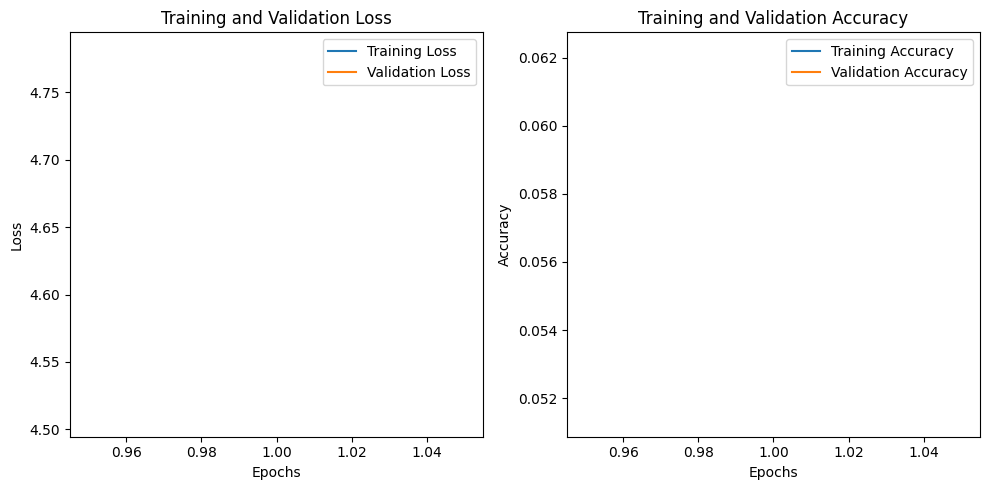

Top-1 accuracy: 0.062, Top-3 accuracy: 0.073, Top-5 accuracy: 0.100, 
Time to calculate: 8.23 seconds
95/95 [==============================] - 121s 1s/step - loss: 4.7808 - accuracy: 0.0514 - weighted_f1_score: 0.0443 - val_loss: 4.5082 - val_accuracy: 0.0622 - val_weighted_f1_score: 0.0296 - lr: 0.0010
Epoch 2/10


KeyboardInterrupt: 

In [27]:
model_sgd, history_sgd = compile_and_train_model(sgd_optimizer, batch_size=128, epochs=10)


In [ ]:
model_adam, history_adam = compile_and_train_model(adam_optimizer, batch_size=128, epochs=10)

#### Let's compare different batch sizes

In [ ]:
model_batch_32, history_batch_32 = compile_and_train_model(sgd_optimizer, batch_size=32, epochs=10)
model_batch_128, history_batch_128 = compile_and_train_model(sgd_optimizer, batch_size=128, epochs=10)

#### Let's check also how it is with class weights

In [ ]:
# Let's visualize quickly how imbalanced our classes are
class_counts = {class_label: 0 for class_label in train_generator.class_indices}

for class_index in train_generator.classes:
    class_label = [label for label, index in train_generator.class_indices.items() if index == class_index][0]
    class_counts[class_label] += 1

labels = list(class_counts.keys())
counts = [class_counts[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

In [ ]:
model_with_class_weights, history_with_class_weights = compile_and_train_model(sgd_optimizer, batch_size=128, epochs=10, use_class_weights=True)

In [ ]:
## Here we should add a part with oversampling to compare
#
#
#
#
#

#### Let's check best model with more aggressive augmentation

In [ ]:
# redefining
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,              # from 40 to 60
    width_shift_range=0.2,          # from 0.1 to 0.2
    height_shift_range=0.2,         # from 0.1 to 0.2
    shear_range=0.2,                # from 0.1 to 0.2
    zoom_range=0.2,                 # from 0.1 to 0.2
    brightness_range=(0.5, 1.5),    # (0.7, 1.3) to (0.5 to 1.5)
    horizontal_flip=True
)

In [ ]:
model_batch_32, history_batch_32 = compile_and_train_model(sgd_optimizer, batch_size=32, epochs=10)

In [ ]:
#### Below HERE everything from before, don't consider

#### Defining data generators

In [ ]:
# Reduce the augmentation slightly
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # reduced from 60
    width_shift_range=0.1,  # reduced from 0.2
    height_shift_range=0.1,  # reduced from 0.2
    shear_range=0.1,  # reduced from 0.2
    zoom_range=0.1,  # reduced from 0.2
    brightness_range=(0.7, 1.3),  # narrowed range
    horizontal_flip=True
)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=60,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     brightness_range=(0.5, 1.5),
#     horizontal_flip=True
# )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128
input_size = (128,128)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical',
        target_size = input_size)

val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

Found 12099 images belonging to 114 classes.
Found 1254 images belonging to 114 classes.
Found 3173 images belonging to 114 classes.


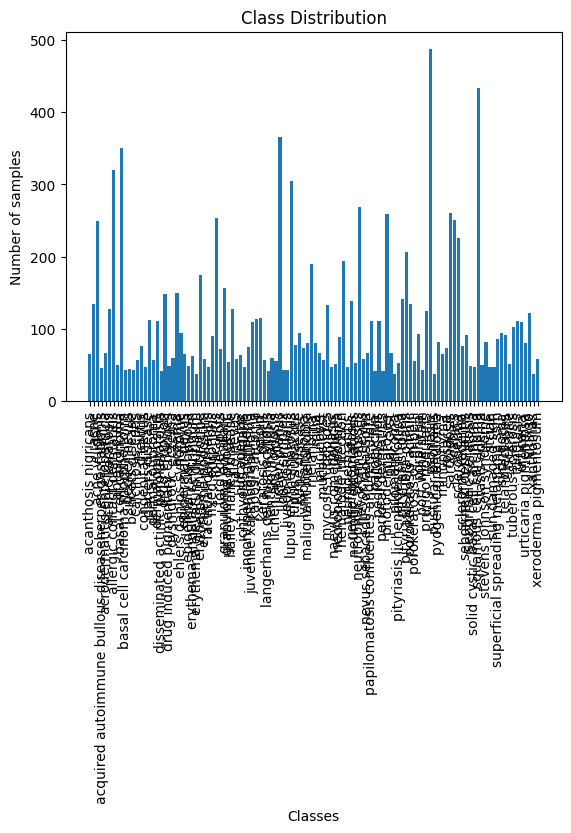

In [ ]:
# Let's visualize quickly how imbalanced our classes are
class_counts = {class_label: 0 for class_label in train_generator.class_indices}

for class_index in train_generator.classes:
    class_label = [label for label, index in train_generator.class_indices.items() if index == class_index][0]
    class_counts[class_label] += 1

labels = list(class_counts.keys())
counts = [class_counts[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


#### Creating Callbacks

In [ ]:
# start_time = time.time()
# top_1_acc = []
# top_3_acc = []
# top_5_acc = []
# for x_val_batch, y_val_batch in tqdm(val_generator):
#     val_predictions = model.predict(x_val_batch, verbose = 0)
#     top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
#     top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
#     top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
#     if len(top_1_acc) >= len(val_generator):
#         break
# end_time = time.time()
# duration = end_time - start_time
# print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')


In [ ]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-n:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')
top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

In [ ]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_metrics_callback = PlotMetricsCallback()

In [ ]:
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

In [ ]:
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1_score')

#### New Try

In [ ]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr=0.001, momentum=0.9)
#optimizer = Adam(learning_rate=0.001)
# Change the base model to VGG16 to simplify
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Make only the top layers of the base model trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False


# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(114, activation='softmax')
])

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score])

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

plot_metrics_callback = PlotMetricsCallback()

top_n_accuracy_callback = TopNAccuracyCallback(val_generator)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Assuming 'train_generator' is already defined and being used in the model training

# Calculate the class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)

class_weights = dict(enumerate(class_weights))


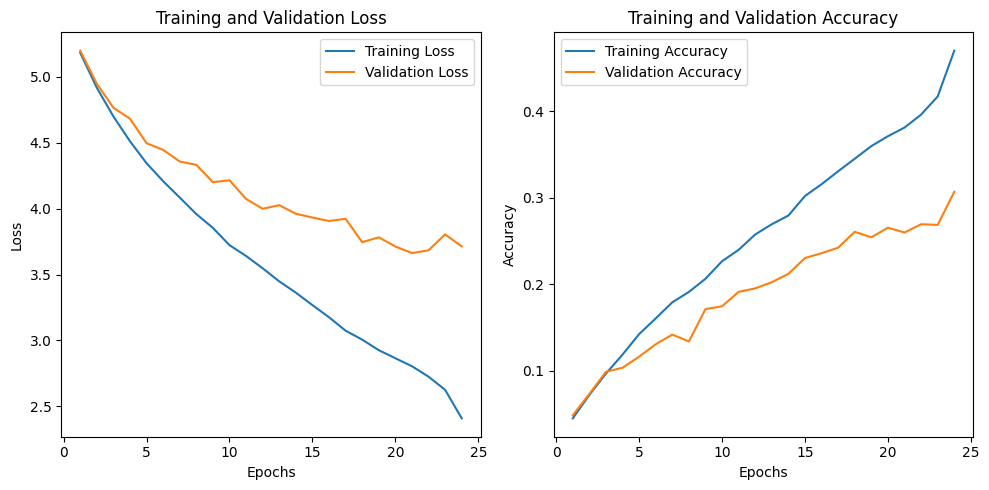

Top-1 accuracy: 0.260, Top-3 accuracy: 0.275, Top-5 accuracy: 0.285, 
Time to calculate: 8.26 seconds
95/95 [==============================] - 119s 1s/step - loss: 2.4082 - accuracy: 0.4701 - weighted_f1_score: 0.4649 - val_loss: 3.7133 - val_accuracy: 0.3070 - val_weighted_f1_score: 0.2871 - lr: 1.0000e-03


In [ ]:
# Fit the model with the updated data augmentation and callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # You can increase epochs if you have the computational capacity
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    # class_weight=class_weights,
    callbacks=[
        reduce_lr,
        early_stopping,
        model_checkpoint,
        clear_output_callback,
        plot_metrics_callback,
        top_n_accuracy_callback
    ],
    verbose=1
)


#### Creating the model

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Handmade model

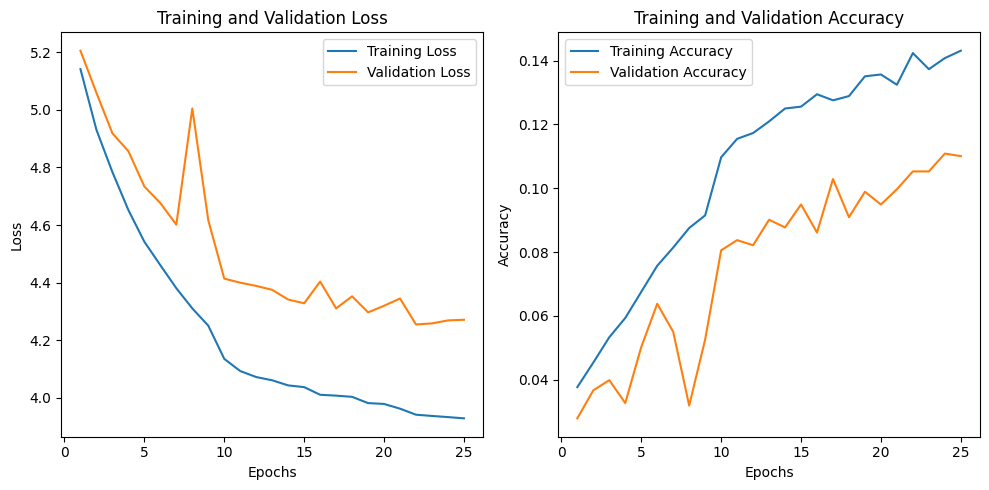

Top-1 accuracy: 0.106, Top-3 accuracy: 0.107, Top-5 accuracy: 0.139, 
Time to calculate: 7.65 seconds
379/379 [==============================] - 115s 304ms/step - loss: 3.9289 - accuracy: 0.1431 - val_loss: 4.2711 - val_accuracy: 0.1100 - lr: 1.0000e-05


In [ ]:
optimizer = SGD(lr=0.001, momentum=0.9)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),   # used instead of flatten
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(114, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Adjust based on computational capacity
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
    verbose=1
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 51, 51, 64)        256       
 chNormalization)                                                
                                                        

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-18-2061bc00d648>", line 7, in <cell line: 7>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,1024], In[1]: [6400,256]
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_train_function_2191]

### VGG

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
        return lr
  else:
        return lr * 0.9

scheduler_callback = LearningRateScheduler(scheduler)

optimizer = Adam(learning_rate=0.00001)

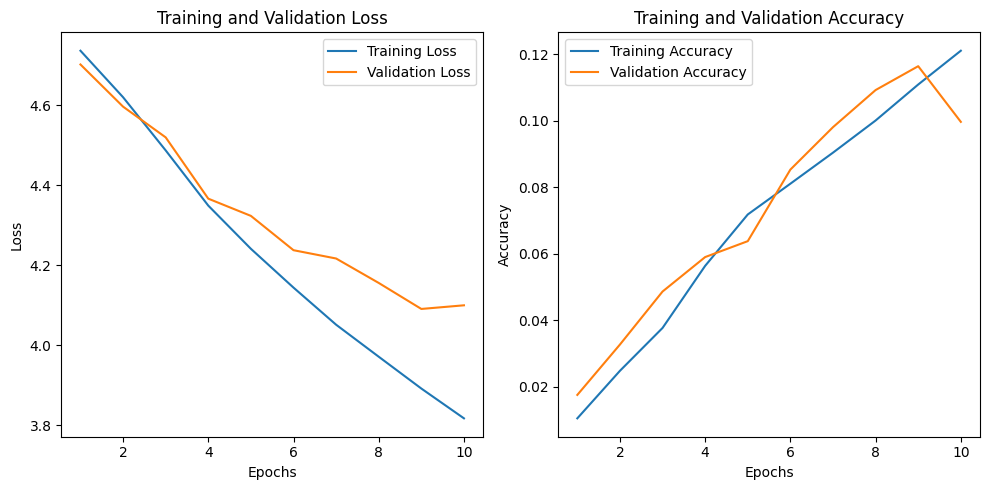

Top-1 accuracy: 0.101, Top-3 accuracy: 0.127, Top-5 accuracy: 0.142, 
Time to calculate: 10.80 seconds
379/379 [==============================] - 131s 345ms/step - loss: 3.8175 - accuracy: 0.1211 - weighted_f1_score: 0.1042 - val_loss: 4.0998 - val_accuracy: 0.0997 - val_weighted_f1_score: 0.0855 - lr: 1.0000e-05


In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

flatten = layers.Flatten()(vgg.output)

dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.3)(dense)

dense = layers.Dense(256, activation='relu')(dense)
dropout = Dropout(0.3)(dense)

output = layers.Dense(114, activation='softmax')(dense)

model = models.Model(vgg.input, output)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score])

# history = model.fit(train_generator,
#           validation_data=val_generator,
#           epochs=10,
#           steps_per_epoch=len(train_generator),
#           validation_steps = len(val_generator),
#           callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
#           verbose = 'auto')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=[
        reduce_lr,
        clear_output_callback,
        plot_metrics_callback,
        top_n_accuracy_callback
    ],
    verbose='auto'
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/MyDrive/Nova IMS/DL/Project/vgg19_weights_baseline_22_03.h5')

#### Further modeling

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# Flatten the output of the VGG16 network because it is a 2D array
flatten = layers.Flatten()(vgg.output)

# Add a fully connected layer with 1024 neurons
dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

# Add a fully connected layer with 256 neurons
dense = layers.Dense(256, activation='relu')(dense)
dropout = Dropout(0.5)(dense)

# We have 114 classes so we need a dense layer with 114 neurons
output = layers.Dense(114, activation='softmax')(dense)

# Create a model
model = models.Model(vgg.input, output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/10
379/379 [==============================] - 214s 565ms/step - loss: 4.5626 - accuracy: 0.0496 - val_loss: 4.6065 - val_accuracy: 0.0439
Epoch 2/10
379/379 [==============================] - 209s 550ms/step - loss: 4.2871 - accuracy: 0.0688 - val_loss: 4.4079 - val_accuracy: 0.0566
Epoch 3/10
379/379 [==============================] - 208s 548ms/step - loss: 4.1713 - accuracy: 0.0774 - val_loss: 4.2941 - val_accuracy: 0.0797
Epoch 4/10
379/379 [==============================] - 212s 560ms/step - loss: 4.0789 - accuracy: 0.0922 - val_loss: 4.2698 - val_accuracy: 0.0813
Epoch 5/10
379/379 [==============================] - 212s 558ms/step - loss: 4.0069 - accuracy: 0.0995 - val_loss: 4.1700 - val_accuracy: 0.0949
Epoch 6/10
379/379 [==============================] - 203s 535ms/step - loss: 3.9411 - accuracy: 0.1079 - val_loss: 4.1259 - val_accuracy: 0.0973
Epoch 7/10
379/379 [==============================] - 205s 541ms/step - loss: 3.8945 - accuracy: 0.1151 - val_loss: 4.0923 -

In [ ]:
model.save_weights('/content/vgg16-1024-256.h5')